In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('our-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAACGCGTGGGGCGACCCCGGAATGCGGCTCTCTAGGCTCCT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTCCAAATAGGTTGTCCTCCGTTTTATCTAA...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACCTCCCACGGGCCGGGCCCCTTGGTTCCCCACCTGCAAGA...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGACGCCCGCAGCGACGCAATTGCGGAGTAAGCGCGTGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACGGATGTAACTCATGGTTCCTCCGTTCCGCCGAGCGCCTTTTG...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCGGGTATATGGTCC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTGGAACGTGTTCCTCCGCCAATAAGGTTGGCTTCTAGTATA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCTTCCGGACAACCGCAAGGGTGCATGCGCGCCGCATTCCCAATT...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACGGGCCGTCCTATGCTGGACATTGAATCCACAACAACGTCTTGCC...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 65201.74it/s]


[101, 357, 581, 794, 1076, 1272, 1492, 1720, 1879, 2062, 2239, 2383, 2560, 2680, 2894, 3003, 3164, 3307, 3453, 3524, 3643, 3740, 3881, 3965, 4017, 4105, 4207, 4261, 4334, 4432, 4517, 4562, 4610, 4682, 4734, 4833, 4850, 4883, 4975, 4954, 5025, 5101, 5072, 5092, 5264, 5245, 5252, 5218, 5263, 5380, 5406, 5493, 5338, 5485, 5583, 5477, 5480, 5383, 5443, 5438, 5385, 5320, 5347, 5299, 5293, 5153, 5211, 5131, 5128, 5109, 5001, 4923, 4942, 4854, 4837, 4778, 4727, 4667, 4572, 4450, 4450, 4369, 4302, 4171, 4162, 4055, 3893, 3870, 3760, 3561, 3429, 3325, 3233, 3161, 2976, 2812, 2656, 2537, 2381, 2195, 2045, 1854, 1644, 1409, 1240, 1033, 755, 515, 232, 49]


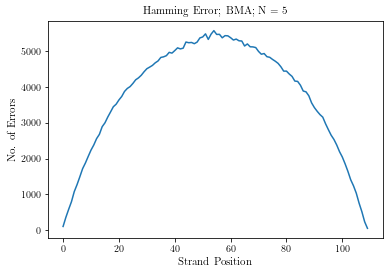

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-our-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:15<00:00, 637.98it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> TGTG 6
 -> GTTC 6
ATTG ->  6
AGCT ->  6
GATG ->  6
TACG ->  6
ATT -> G 6
GTA -> C 6
ATC -> G 6
TGGT ->  6
ATTA ->  6
G -> CCT 6
AA -> TC 6
 -> CTTC 6
 -> GGCCC 6
GTTA ->  6
 -> ACCC 6
GTG -> C 6
AATG ->  6
G -> CTT 6
 -> GTGG 6
AA -> TG 6
 -> CGGA 6
A -> GGGCG 6
A -> GTC 6
 -> GCTC 6
ATGG ->  6
CATA ->  6
TGAA ->  6
 -> CCGA 6
TTAA ->  6
 -> CGTC 6
ATGA ->  6
AGTG ->  6
 -> TTGG 6
T -> GCGC 6
AT -> CCC 6
 -> TTCG 6
GCTA ->  6
AT -> CGC 6
 -> CGGT 6
 -> GAGT 6
CA -> TT 6
T -> CCCCC 6
AGAG ->  6
 -> CGCCC 6
CCA -> T 6
 -> CGCG 6
AAGT ->  6
 -> CGTT 6
ACAT ->  6
AGAC ->  6
GCC ->  6
 -> TCCG 7
 -> AAGT 7
GA -> CT 7
T -> GCGG 7
 -> CCTA 7
 -> CCTT 7
GCTT ->  7
AA -> CT 7
 -> GCCT 7
GGCA ->  7
 -> GTCC 7
TCC ->  7
ACGA ->  7
 -> CTTT 7
ATAG ->  7
GGA -> C 7
T -> CCA 7
A -> CGT 7
GG -> A 7
ACTA ->  7
G -> ACC 7
T -> AGG 7
ATGC ->  7
CTGA ->  7
CCT ->  7
AAGC ->  7
GACT ->  7
TATA ->  7
 -> CCGT 7
 -> CTCT 7
TACT ->  7
GCGA ->  7
AGAT ->  7
AAT -> G 7
 -> TCGG 7
AC -> TG 7
A -> GGCC 7
 ->

TC ->  @ 52 6
C -> G @ 11 6
 -> GT @ 50 6
C -> G @ 107 6
 -> GC @ 78 6
 -> GT @ 56 6
T -> GG @ 63 6
TA ->  @ 48 6
C -> G @ 36 6
AA ->  @ 61 6
TA ->  @ 21 6
TA ->  @ 22 6
T -> A @ 27 6
C -> G @ 27 6
TC ->  @ 57 6
CG ->  @ 37 6
CG ->  @ 52 6
TA ->  @ 40 6
T -> A @ 22 6
 -> GC @ 51 6
TA ->  @ 44 6
TA ->  @ 45 6
AA ->  @ 47 6
C -> G @ 102 6
CT ->  @ 42 6
GA ->  @ 91 6
TA ->  @ 97 6
C -> A @ 9 6
AT ->  @ 82 6
AT ->  @ 81 6
GA ->  @ 42 6
 -> CC @ 88 6
C -> A @ 92 6
 -> CC @ 41 6
A -> GC @ 18 6
 -> TG @ 64 6
AT ->  @ 67 6
AT ->  @ 65 6
 -> TG @ 51 6
 -> CG @ 57 6
AT ->  @ 52 6
GA ->  @ 27 6
AT ->  @ 75 6
TA ->  @ 63 6
 -> CC @ 62 6
TA ->  @ 92 6
T -> A @ 16 6
TA ->  @ 66 6
 -> CGG @ 55 6
CT ->  @ 26 6
TA ->  @ 69 6
TA ->  @ 72 6
AT ->  @ 99 6
 -> CA @ 13 6
TA ->  @ 73 6
GA ->  @ 78 6
GA ->  @ 76 6
AA ->  @ 42 6
T -> A @ 13 6
GA ->  @ 69 6
TA ->  @ 88 6
TA ->  @ 89 6
 -> GTT @ 54 6
C -> G @ 37 6
AA ->  @ 83 6
TA ->  @ 17 6
 -> CCC @ 52 6
 -> CCC @ 54 6
C -> A @ 102 6
C -> T @ 80 6
GT ->  @ 82 

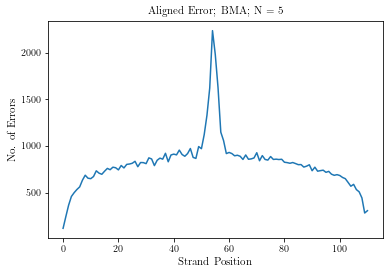

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-our-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 44, 45, 65, 68, 56, 80, 79, 88, 73, 67, 91, 89, 102, 82, 77, 104, 79, 84, 108, 78, 95, 67, 99, 86, 96, 74, 96, 88, 92, 74, 90, 109, 87, 106, 100, 87, 96, 91, 93, 100, 101, 98, 89, 84, 95, 103, 80, 91, 88, 91, 95, 89, 93, 119, 105, 83, 68, 84, 104, 92, 89, 96, 95, 88, 84, 113, 71, 94, 85, 106, 92, 92, 101, 90, 89, 80, 92, 93, 94, 96, 98, 83, 92, 93, 71, 90, 78, 89, 78, 75, 96, 75, 91, 84, 101, 79, 70, 82, 102, 94, 89, 79, 89, 78, 77, 70, 68, 45, 49, 42]
[0, 31, 34, 39, 37, 42, 45, 67, 63, 53, 63, 60, 51, 55, 56, 60, 84, 60, 65, 65, 57, 65, 59, 67, 70, 58, 61, 63, 66, 62, 69, 58, 57, 53, 65, 75, 77, 68, 54, 76, 77, 66, 92, 65, 62, 82, 67, 70, 65, 79, 64, 73, 71, 92, 102, 138, 91, 67, 71, 46, 65, 73, 75, 62, 67, 67, 65, 70, 79, 75, 72, 59, 69, 67, 74, 63, 73, 61, 72, 70, 63, 53, 71, 65, 64, 74, 70, 57, 68, 48, 56, 64, 62, 72, 58, 59, 67, 58, 58, 58, 54, 62, 55, 57, 54, 50, 35, 43, 61, 39, 32]
[34, 26, 35, 33, 31, 32, 43, 47, 51, 47, 43, 49, 50, 49, 44, 50, 46, 52, 49, 52, 43, 50, 53, 

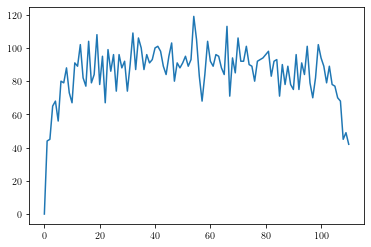

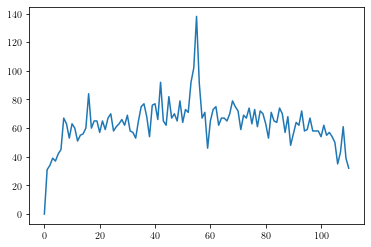

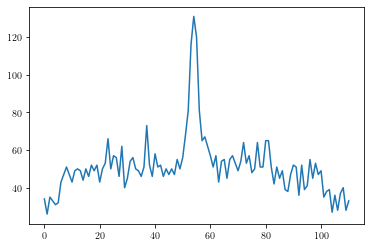

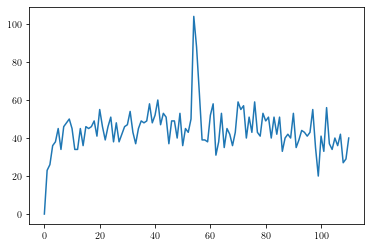

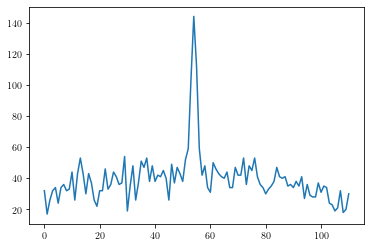

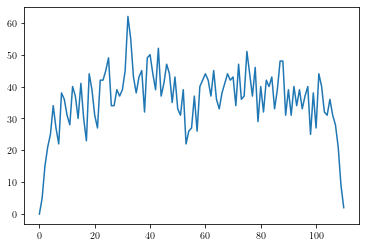

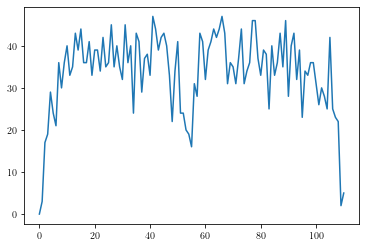

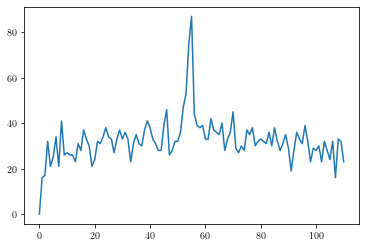

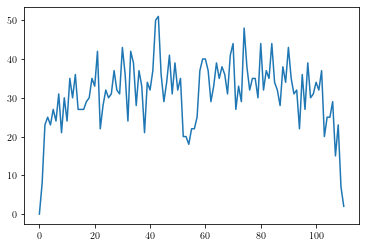

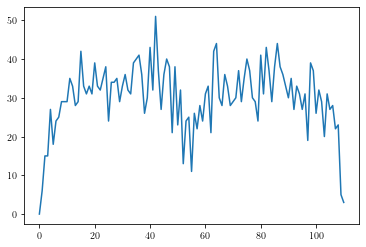

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)